In [16]:
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import lightgbm as lgbm
from tabulate import tabulate

from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn.metrics as met
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [17]:
def treat_data(df_1):
    new_keys = ["Municipio"]
    tags = ["Total", "Primario", "Secundario"]
    new_keys += ["Plantas de tratamiento en operación: " + tag for tag in tags]
    new_keys += ["Capacidad instalada (Litros por segundo): " + tag for tag in tags]
    new_keys += ["Volumen tratado   (Millones de metros cúbicos): " + tag for tag in tags]
    df_1 = df_1.set_axis(new_keys, axis = 1)
    df_1 = df_1.drop([0,1,2], axis = 0).reset_index().drop("index", axis = 1)
    
    
    lista_municipios = []
    mun_row = df_1["Municipio"]
    indice_ultimo_municipio = 0
    
    for i in range(len(mun_row)):
        municipio = mun_row[i]
        if municipio not in ["Público", "Privado"]:
            indice_ultimo_municipio = i
            lista_municipios.append(municipio)
        else:
            lista_municipios.append(mun_row[indice_ultimo_municipio])
    
    df_1["Municipio_nuevo"] = lista_municipios
    
    for i in range(len(df_1)):
        if df_1["Municipio"].loc[i] not in ["Público", "Privado"]:
            df_1 = df_1.drop(i, axis = 0)
    df_1 = df_1.rename(columns = {"Municipio": "Tipo"})
    df_1 = df_1.rename(columns = {"Municipio_nuevo": "Municipio"})
    key = ["Municipio"] + list(df_1.keys()[:-1])
    df_1 = df_1[key].reset_index().drop("index", axis = 1)
    return(df_1)

In [18]:
def difference(p1, p2):
    dif = np.sqrt(np.sum(((p1 - p2))**2))
    return dif

In [19]:
data = pd.read_csv("Datos_limpios.csv", index_col = 0).drop(["Plantas de tratamiento en operación: Total", "Capacidad instalada (Litros por segundo): Total", "Volumen tratado   (Millones de metros cúbicos): Total", "Viviendas particulares habitadas con agua entubada"], axis = 1)
data = data.replace('NS',np.NaN)
data = data.dropna().reset_index(drop = True)
data

,Municipio,Tipo,Plantas de tratamiento en operación: Primario,Plantas de tratamiento en operación: Secundario,Capacidad instalada (Litros por segundo): Primario,Capacidad instalada (Litros por segundo): Secundario,Volumen tratado (Millones de metros cúbicos): Primario,Volumen tratado (Millones de metros cúbicos): Secundario,Diaria,Cada tercer día,Una o dos veces a la semana,Esporádica,No especificado
0,Acateno,Público,0,1,0,1.8,0,0.06,57.731158,26.495726,10.334110,4.351204,1.087801
1,Acatlán,Privado,1,0,1.25,0,1.25,0,3.887312,19.960690,70.037126,5.678096,0.436777
2,Ahuacatlán,Público,0,3,0,56,0,1.77,66.775244,18.494390,10.821571,3.764025,0.144770
3,Ajalpan,Privado,2,0,6.1,0,0.1,0,19.783085,25.195537,39.409740,15.465638,0.146001
4,Aljojuca,Público,0,2,0,8.54,0,0.2693,32.111252,43.994943,19.721871,3.919090,0.252845
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,Xicotepec,Privado,0,11,0,23.5,0,0.7,81.995413,12.324609,2.091203,3.494334,0.094441
58,Xochiltepec,Público,0,1,0,5.2,0,0.164,36.514523,58.644537,3.319502,1.521438,0.000000
59,Zacapoaxtla,Público,0,1,0,2.7,0,0.0852,50.369588,29.809926,16.800422,2.893347,0.126716
60,Zacatlán,Público,1,2,20,81.11,0.3784,2.5579,63.752389,24.582280,10.123929,1.276281,0.265121


In [20]:
x = pd.get_dummies(data.Tipo, sparse=True).to_numpy()
train_data = data.to_numpy()
X = X_train = np.column_stack([x, train_data[:,2:8]]).astype(float)
y = y_train = train_data[:,8:]/100

RMSE promedio del SVR: 15.4636263200509


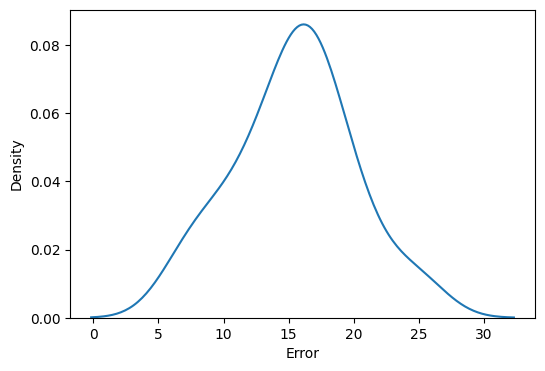

In [21]:
svr = SVR(kernel = "rbf", C = 0.46)
clf = MultiOutputRegressor(svr)

mse = met.make_scorer(met.mean_squared_error)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

svr_scores = np.sqrt(cross_val_score(clf, X, y, cv=30, scoring = mse))*100

print(f"RMSE promedio del SVR: {np.mean(svr_scores)}")

fig = plt.figure(figsize = (6, 4))
sns.kdeplot(x = svr_scores)
plt.xlabel("Error")
fig.savefig("KDE error.png", format = "png", dpi = 300)
plt.show()

In [26]:
print(X.shape)
print(y.shape)

(62, 8)
(62, 5)


In [38]:
svr = SVR(kernel = "rbf", C = 0.46)
mor = MultiOutputRegressor(svr)
X_train, y_train = X[5:], y[5:]
mor.fit(X_train, y_train)

MultiOutputRegressor(estimator=SVR(C=0.46))

In [39]:
X_test, y_test = X[:5], y[:5]

y_pred_svr = mor.predict(X_test)

y_pred_norm_svr = y_pred_svr/np.asarray([y.sum() for y in y_pred_svr]).reshape(-1,1)
percentages = (y_pred_norm_svr*100).astype(int)
pred_data = np.column_stack((data["Municipio"].to_numpy()[:5], percentages))

real_data = np.column_stack((data["Municipio"].to_numpy()[:5], (y_test*100).astype(int)))

head = ["Municipio", "Diaria", "Cada tercer día", "Una o dos veces a la semana", "Esporádica", "No especificado"]

table = tabulate(pred_data, headers = head, tablefmt = "csv")
print("Resultados por SVM:\n" + table)

real_table = tabulate(real_data, headers = head, tablefmt = "csv")
print("Datos reales:\n" + real_table)

print(difference(y_pred_svr*100, y_test*100))

Resultados por SVM:
Municipio      Diaria    Cada tercer día    Una o dos veces a la semana    Esporádica    No especificado
-----------  --------  -----------------  -----------------------------  ------------  -----------------
Acateno            35                 27                             21            11                  3
Acatlán            35                 27                             21            11                  3
Ahuacatlán         41                 27                             16            10                  3
Ajalpan            35                 27                             21            11                  3
Aljojuca           36                 27                             20            11                  3
Datos reales:
Municipio      Diaria    Cada tercer día    Una o dos veces a la semana    Esporádica    No especificado
-----------  --------  -----------------  -----------------------------  ------------  -----------------
Acateno            57